# Expand window

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Import Libraries

In [26]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load Data

In [3]:
train_data = pd.read_csv("../../data/train/encoded.csv")

In [4]:
print(train_data.shape)
train_data.sample(5)

(164309, 12)


,Loan_Amount_Requested,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Experience
140971,15000.0,0,55000.0,2,2,15.95,1,6,23,0,2,10.0
60069,16000.0,4,75000.0,2,2,17.70,0,9,12,1,2,8.0
37928,4200.0,0,56700.0,0,4,13.48,1,11,44,1,2,10.0
31186,9600.0,0,131678.0,2,9,25.91,4,14,47,0,3,10.0
70681,14000.0,4,63000.0,2,2,4.36,0,24,57,0,1,0.5


# Split X and Y

In [5]:
target = 'Interest_Rate'
X = train_data.drop(target, axis = 1)
y = train_data[target]

In [6]:
X.shape

(164309, 11)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Train data size", X_train.shape[0])
print("Test data size", X_test.shape[0])

Train data size 131447
Test data size 32862


# Model Selection

In [8]:
def get_random_forest_params_dict():
    # Random Forest Parameters
    n_estimators = [100,200,300,400] # Number of decision trees in random forest
    max_features = ['auto', 'sqrt'] # Number of features to consider at every split
    max_depth = [10,20,30,40,50,60] # Maximum number of levels in tree
    bootstrap = [True, False] # Method of selecting samples for training each tree

    rf_param_grid = dict(max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap)
    
    return rf_param_grid

In [9]:
def get_decision_tree_params_dict():
    criterion = ['gini', 'entropy']
    max_depth = [1,2,3,4,6,8,12]

    deci_tree_parm_grid = dict(criterion = criterion, max_depth = max_depth)
    
    return deci_tree_parm_grid

In [10]:
def get_knn_params_dict():
    
    knn_range = list(range(5,11))
    weight_options = ["uniform", "distance"]

    knn_param_grid = dict(n_neighbors = knn_range, weights = weight_options)

    return knn_param_grid

In [11]:
def get_svm_params_dict():
    svm_param_grid = dict(C = [0.1, 1, 5], gamma = [1, 0.1,  0.001], kernel = ['rbf', 'poly', 'sigmoid'])

    return svm_param_grid

In [37]:
def process_models(train_features, train_target, test_features, test_target):
    
    features_selected = list(train_features.columns.values)
    
    # Models which we are going to analyse
    base_models = {
#         'KNN': KNeighborsClassifier(),
#         'DecisionTree': DecisionTreeClassifier(random_state=10),
        'RandomForest': RandomForestClassifier(random_state=10),
#         'SVM': SVC()
    }

    # Model's parameters required for hypterparameter tuning
    params_grid = {
#         'KNN': get_knn_params_dict(),
#         'DecisionTree': get_decision_tree_params_dict(),
        'RandomForest': get_random_forest_params_dict(),
#         'SVM': get_svm_params_dict()
    }
    
    # Array to Store all models summary
    model_summary_lst = []
    
    for name in base_models.keys():

        # Base estimator or model
        estimator = base_models[name] 
        
        #================================== Scale features ============================================
        if name == 'KNN':
            # KNN performs very well when data is scaled. So we first scale the data and them fit it 
            print("Data scaled for KNN")
            scalar = StandardScaler()

            train_features = scalar.fit_transform(train_features)
            test_features = scalar.fit_transform(test_features)
        
        
        #================================== Base Model ============================================
        base_model = estimator
        
        # Fit model
        base_model.fit(train_features, train_target)
        
        #Predict test data using base model
        base_y_pred = base_model.predict(test_features)
        
        #Base model accuracy
        base_accuracy = accuracy_score(test_target, base_y_pred) 
        
        
        
        #================= Best fit Model with parameter tuning ===================================
        
        
        #RandomizedSearchCV model with parameter tuning
        est_params = params_grid[name] 
        random_search_cv = RandomizedSearchCV(estimator, est_params, n_iter=12, cv=10, verbose=0, n_jobs=-1,random_state=10)
       
        # Fit RandomizedSearchCV object
        random_search_cv.fit(train_features, train_target)
        
        #Predict test data using best fit model
        random_search_cv_y_pred = random_search_cv.predict(test_features)
        
        #Best fit accuracy
        best_fit_accuracy = accuracy_score(test_target, random_search_cv_y_pred)  
        
        #================= Create dataframe with accuracy summary details ===================================
         
        #Calculate the improvemnt of best fit model's accuracy over our base model accuracy
        improvement ='{:0.3f}%.'.format( 100 * (best_fit_accuracy - base_accuracy) / base_accuracy)

        #Add summary to object
        model_summary_lst.append([name, train_features.shape[1], base_accuracy, best_fit_accuracy, improvement, random_search_cv.best_estimator_])
        
        
    # Columns we are interested
    columns = ['Model', 'Total_Features', 'Base_Accuracy', 'Best_Fit_Accuracy', 'Improvement', "Best_Estimator"]
    
    # Convert our models summary to dataframe 
    result = pd.DataFrame(model_summary_lst, columns= columns)
    
    return result

## Model Summary for differnt range of features

### Choose all features from data

In [ ]:
all_features_result_df = process_models(X_train, y_train, X_test, y_test)
all_features_result_df.head()

In [21]:
### Combine dataframes 
combined_data = pd.concat([all_features_result_df], ignore_index=True)
combined_data

,Model,Total_Features,Base_Accuracy,Best_Fit_Accuracy,Improvement,Best_Estimator
0,DecisionTree,11,0.418629,0.504078,20.411%.,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


### Plot graph for combined dataframes with different features range

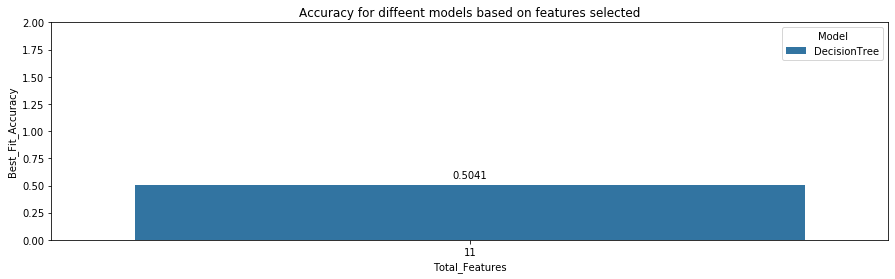

In [36]:
fig, ax = plt.subplots(figsize=(15,4))
chart = sns.barplot(x = 'Total_Features', y = 'Best_Fit_Accuracy', hue = 'Model', data = combined_data)
 
# Chart customization
chart.set_title('Accuracy for diffeent models based on features selected')
chart.set(ylim=(0, 2)) # Set max value to more than '1' to see(including legend) the value on graph properly

# Annotate each bar in graph with it's value
for p in chart.patches: 

    display_text = "{0:.4f}".format(p.get_height())
    chart.annotate(display_text, (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    